## This next assignment is a quick basic tutorial of one of the possible applications of the RNN - NLP with name classification and generation.


### Task 1. Go over to https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html . 
### Go through the tutorial, understand the code and implement it here.

In [1]:
#Begin your code here, feel free to use more cells for organizing your code.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(len(all_categories), all_categories)
# print(category_lines)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski
18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [3]:
# Turning Names into Tensors
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
# Creating the Network
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)
rnn = RNN(len(all_letters), n_hidden, len(all_categories))

In [5]:
# run a step of this network
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8137, -3.0301, -2.9166, -2.8530, -2.8719, -2.8852, -2.8345, -2.8504,
         -2.8922, -2.7895, -2.9280, -2.8328, -2.9979, -2.9199, -2.9640, -2.9865,
         -2.9133, -2.7896]], grad_fn=<LogSoftmaxBackward>)


In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8137, -3.0301, -2.9166, -2.8530, -2.8719, -2.8852, -2.8345, -2.8504,
         -2.8922, -2.7895, -2.9280, -2.8328, -2.9979, -2.9199, -2.9640, -2.9865,
         -2.9133, -2.7896]], grad_fn=<LogSoftmaxBackward>)


In [7]:
# Preparing for Training
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 9)


In [8]:
# a quick way to get a training example (a name and its language)
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Salvage
category = English / line = Ripley
category = Irish / line = Peatain
category = Chinese / line = OuYang
category = Dutch / line = Robert
category = French / line = Rousseau
category = Russian / line = Emelin
category = Irish / line = Ceallach
category = French / line = Babineaux
category = Korean / line = Jeong


In [9]:
# Training the Network
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [11]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t %d%% \t (%s) \t %.4f %20s / %-20s \t %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 	 5% 	 (0m 10s) 	 3.0942 	 Gerig / Chinese 	 ✗ (German)
10000 	 10% 	 (0m 22s) 	 2.8881 	 Ross / Arabic 	 ✗ (Scottish)
15000 	 15% 	 (0m 33s) 	 2.1975 	 Oleastro / Portuguese 	 ✗ (Spanish)
20000 	 20% 	 (0m 42s) 	 2.3175 	 Frankish / Italian 	 ✗ (English)
25000 	 25% 	 (0m 52s) 	 0.2057 	 Antonopoulos / Greek 	 ✓
30000 	 30% 	 (1m 1s) 	 4.0930 	 Maly / Irish 	 ✗ (Czech)
35000 	 35% 	 (1m 12s) 	 1.4463 	 Kirchma / Czech 	 ✓
40000 	 40% 	 (1m 22s) 	 0.6274 	 Rebka / Czech 	 ✓
45000 	 45% 	 (1m 32s) 	 2.4740 	 Clark / Czech 	 ✗ (Scottish)
50000 	 50% 	 (1m 44s) 	 3.4595 	 Hadjula / Spanish 	 ✗ (Russian)
55000 	 55% 	 (1m 53s) 	 0.2880 	 Fernandes / Portuguese 	 ✓
60000 	 60% 	 (2m 3s) 	 2.1718 	 Dinko / Russian 	 ✗ (Czech)
65000 	 65% 	 (2m 14s) 	 0.2554 	 Horiatis / Greek 	 ✓
70000 	 70% 	 (2m 26s) 	 1.2517 	 Ngo / Korean 	 ✗ (Vietnamese)
75000 	 75% 	 (2m 36s) 	 1.4190 	 Pell / English 	 ✓
80000 	 80% 	 (2m 48s) 	 0.4749 	 O'Shea / Irish 	 ✓
85000 	 85% 	 (3m 0s) 	 5.2293 	 Muru / 

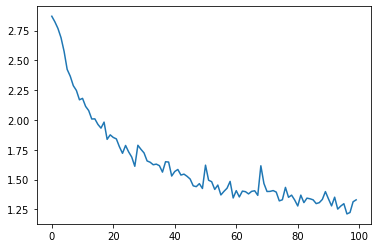

In [12]:
# Plotting the historical loss from all_losses shows the network learning:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Task 2. Now use the dataset of Kazakh names supplied with this assignment, and include it with the original 18 datasets. Now, you should have 19 name datasets. Rerun the code up to the confusion matrix part (excluding it).

In [13]:
Completed = True #Set it to true once done. 

In [45]:
filename = './Kazakh.txt'
category = os.path.splitext(os.path.basename(filename))[0]
all_categories.append(category)
lines = readLines(filename)
category_lines[category] = lines
print(len(all_categories), all_categories)

19 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese', 'Kazakh']


In [19]:
rnn = RNN(len(all_letters), n_hidden, len(all_categories))

In [27]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
#         print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        print('%d \t %d%% \t (%s) \t %.4f %20s / %-20s \t %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))


    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 	 5% 	 (0m 9s) 	 3.0215                  Baz / Chinese              	 ✗ (Arabic)
10000 	 10% 	 (0m 19s) 	 0.6960                 Hong / Korean               	 ✓
15000 	 15% 	 (0m 30s) 	 1.9808                Acqua / Portuguese           	 ✗ (Italian)
20000 	 20% 	 (0m 40s) 	 2.6764                Leone / French               	 ✗ (Italian)
25000 	 25% 	 (0m 50s) 	 0.8162               Obando / Spanish              	 ✓
30000 	 30% 	 (0m 59s) 	 0.0747                 Tong / Vietnamese           	 ✓
35000 	 35% 	 (1m 9s) 	 1.3164              Sinagra / Spanish              	 ✗ (Italian)
40000 	 40% 	 (1m 18s) 	 2.2300               Russon / Scottish             	 ✗ (English)
45000 	 45% 	 (1m 28s) 	 1.5705               Tobias / Portuguese           	 ✗ (French)
50000 	 50% 	 (1m 37s) 	 0.6114                 Lobo / Portuguese           	 ✓
55000 	 55% 	 (1m 46s) 	 0.4623                  You / Korean               	 ✓
60000 	 60% 	 (1m 56s) 	 0.7840              Douglas / Scottish   

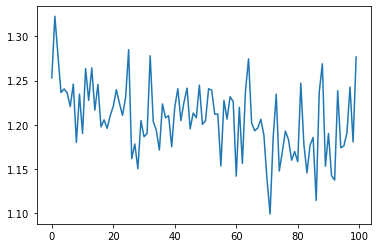

In [28]:
plt.figure()
plt.plot(all_losses)

### Task 3. Plot the confusion matrix of the names, and write 5-6 sentences on the notable things that you observe. Why do we use the confusion matrix? 

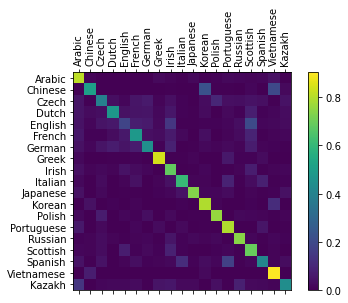

In [29]:
#Your code here
# Keep track of correct guesses in a confusion matrix
n_categories = len(all_categories)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Task 4. Run the predictions on the following

In [30]:
# Running on User Input
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.20) Russian
(-2.02) Czech
(-3.65) English

> Jackson
(-1.04) English
(-1.52) Russian
(-1.83) Scottish

> Satoshi
(-0.15) Arabic
(-2.97) Japanese
(-3.43) Italian


In [31]:
predict('Yoda')
predict('Windu')
predict('Kenobi')


> Yoda
(-0.60) Japanese
(-2.44) Korean
(-2.52) Kazakh

> Windu
(-1.53) Scottish
(-1.78) German
(-1.99) English

> Kenobi
(-0.57) Arabic
(-1.04) Japanese
(-3.24) Italian


In [ ]:
predict('Okabe')
predict('Christina')
predict('Kurisu')
predict('Ruka')
predict('Steins')
predict('Leskinen')
predict('Maho')

In [ ]:
predict('Dmitriy')
predict('Vlad')
predict('Kaisar')
predict('Caesar')
predict('Andrey')
predict('Sabir')
predict('Abay')
predict('Atabay')
predict('Rustem') #essential, don't forget!

### Task 5. Repeat tasks 1 & 4 but with https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html.
#### No need to delete the Kazakh Names dataset, keep it (19 datasets total)

In [54]:
#Start your code here
print(len(all_categories), all_categories)

19 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese', 'Kazakh']


from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

In [55]:
# Creating the Network
import torch
import torch.nn as nn

n_categories = len(all_categories)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Preparing for Training
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [56]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [57]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [58]:
# Training the Network
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [59]:
# Training

rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s \t (%6d %3d%%) \t %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s 	 (  5000   5%) 	 3.1282
0m 25s 	 ( 10000  10%) 	 2.4059
0m 39s 	 ( 15000  15%) 	 2.8968
0m 52s 	 ( 20000  20%) 	 2.7593
1m 5s 	 ( 25000  25%) 	 2.4985
1m 18s 	 ( 30000  30%) 	 3.5779
1m 31s 	 ( 35000  35%) 	 2.9148
1m 44s 	 ( 40000  40%) 	 2.6305
1m 57s 	 ( 45000  45%) 	 1.5692
2m 9s 	 ( 50000  50%) 	 2.6944
2m 22s 	 ( 55000  55%) 	 2.7874
2m 36s 	 ( 60000  60%) 	 2.9654
2m 49s 	 ( 65000  65%) 	 1.6303
3m 2s 	 ( 70000  70%) 	 4.1167
3m 15s 	 ( 75000  75%) 	 2.4135
3m 28s 	 ( 80000  80%) 	 1.9110
3m 41s 	 ( 85000  85%) 	 2.5333
3m 54s 	 ( 90000  90%) 	 2.4585
4m 14s 	 ( 95000  95%) 	 1.9302
4m 26s 	 (100000 100%) 	 2.4210


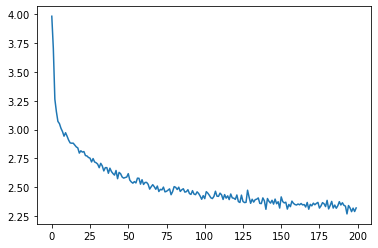

In [60]:
# Plotting the Losses
plt.figure()
plt.plot(all_losses)

In [61]:
# Sampling the Network
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovevak
Uantovov
Santanovov
Ganten
Eren
Ranger
Santa
Pareza
Allan
Chan
Han
Iung


In [62]:
samples('Russian', 'ASDFG')

Altanovevsk
Shinovev
Danivak
Farishov
Gariski


In [63]:
samples('German', 'ASDFG')

Arten
Shant
Derter
Ferter
Gerter


In [64]:
samples('Spanish', 'ASDFG')

Allan
Santa
Danez
Farez
Gander


In [65]:
samples('Kazakh', 'ASDFG')

Alan
Sanima
Danima
Fari
Guant
